In [1]:
#| default_exp tbats

# TBATS model 

In [16]:
#| export
import os
import numpy as np 
from numba import njit 
from scipy.optimize import minimize_scalar
import statsmodels.api as sm 
from statsmodels.tsa.stattools import adfuller

In [4]:
#| export 
# Global variables 
NOGIL = os.environ.get('NUMBA_RELEASE_GIL', 'False').lower() in ['true']
CACHE = os.environ.get('NUMBA_CACHE', 'False').lower() in ['true']

## Load data 

In [393]:
#| hide 
# AirPassengers 
from statsforecast.utils import AirPassengers as ap 

# USAccDeaths
deaths = np.array([9007,  8106,  8928,  9137, 10017, 10826, 11317, 10744,  9713,  9938,  9161,  8927,
7750,  6981,  8038,  8422,  8714,  9512, 10120,  9823,  8743,  9129,  8710,  8680,
8162,  7306,  8124,  7870,  9387,  9556, 10093,  9620,  8285,  8466,  8160,  8034,
7717,  7461,  7767,  7925,  8623,  8945, 10078,  9179,  8037,  8488,  7874,  8647,
7792,  6957,  7726,  8106,  8890,  9299, 10625,  9302,  8314,  8850,  8265,  8796,
7836,  6892,  7791,  8192,  9115,  9434, 10484,  9827,  9110,  9070,  8633,  9240])

# Electricity consumption
import pandas as pd 
elec_df = pd.read_csv('/Users/marianamenchero/Documents/tbats/data/PJMW_hourly.csv')
elec = elec_df['PJMW_MW']
elec = elec[0:(24*7*2+1)]
elec = np.array(elec)

# Calls 
calls_df = pd.read_csv('/Users/marianamenchero/Documents/tbats/data/calls_data.csv')
calls = calls_df['calls']
calls = calls[-2001:]
calls = np.array(calls) 

## Box-Cox Transformation

In [7]:
#| exporti
@njit(nogil=NOGIL, cache=CACHE)
def guer_cv(lam, x, season_length): 
    
   """Minimize this funtion to find the optimal parameter for the Box-Cox transformation."""
   period = np.round(np.max(season_length)) 
   n = len(x) 
   nyears = int(np.floor(n/period))
   nobs = np.floor(nyears*period)
   m = int(n-nobs)
   xmat = x[m:n].reshape((nyears, period))

   xmean = np.full(xmat.shape[0], fill_value = np.nan)
   for k in range(xmat.shape[0]): 
      xmean[k] = np.nanmean(xmat[k])

   xsd = np.full(xmat.shape[0], fill_value = np.nan)
   for k in range(xmat.shape[0]): 
      vals = xmat[k]
      svar = (vals-np.nanmean(vals))**2 
      svar = np.sum(svar)/len(svar) 
      xsd[k] = np.sqrt(svar) 

   xrat = xsd/(xmean**(1-lam))

   sd = (xrat-np.nanmean(xrat))**2 
   sd = np.nansum(sd)/(len(sd)-1)
   sd = np.sqrt(sd)
   
   return sd/np.nanmean(xrat)

In [8]:
#| exporti
def guerrero(x, season_length, lower=0, upper=1): 
    
    """Finds optimal paramater for Box-Cox transformation using Guerrero's method"""
    
    if np.any(x < 0): 
        raise ValueError("Guerrero's method for selecting a Box-Cox parameter (w) is for strictly positive data")
    
    max_freq = np.max(season_length)
    if len(x) <= 2*max_freq: 
        res = 1
    else: 
        w = 0 # initial guess 
        opt = minimize_scalar(guer_cv, w, args = (x, season_length), method = 'bounded', bounds = (lower, upper))
        res = opt.x

    return res

In [9]:
#| exporti
@njit(nogil=NOGIL, cache=CACHE)
def BoxCox(y, BoxCox_lambda): 
    
    """Applies Box-Cox transformation with parameter BoxCox_lambda"""

    if BoxCox_lambda == 0: 
        z = np.log(y)
    else: 
        z = np.sign(y)*((np.abs(y)**BoxCox_lambda)-1)
        z = z/BoxCox_lambda
        
    return z

In [10]:
#| exporti
@njit(nogil=NOGIL, cache=CACHE)
def InverseBoxCox(z, BoxCox_lambda): 
    
    """Inverts Box-Cox transformation with parameter BoxCox_lambda"""

    if BoxCox_lambda == 0: 
        y = np.exp(z) 
    else: 
        sign = np.sign(BoxCox_lambda*z+1)
        y = np.abs(BoxCox_lambda*z+1)**(1/BoxCox_lambda)
        y = sign*y 
        
    return y 

## Functions 

### find_harmonics

In [384]:
#| exporti
def find_harmonics(y, seasonal_periods, k):

    # Compute a 2 x m moving average to estimate the trend 
    m = seasonal_periods[k]
    window_size = 2 * m
    data = pd.DataFrame({'value': y})
    f_t = data['value'].rolling(window = window_size, center = True).mean()
    
    # Obtain an approximation of seasonal component using z_t = y_t - f_t 
    data['f_t'] = f_t
    data['z_t'] = data['value']-data['f_t']

    # Drop missing values (due to the moving average)
    data.dropna(inplace = True) 

    if data.empty:
        return 1

    # Approximate the seasonal component using trigonometric terms
    t = np.arange(len(data))
    if m % 2 == 0: 
        max_harmonics = int(m/2)
    else: 
        max_harmonics = int((m-1)/2)

    max_harmonics = min(max_harmonics, len(data))
    
    aic = np.inf
    num_harmonics = 0
    for h in range(1,max_harmonics+1): 
        columns = []
        for i in range(1, h+1):
            data[f'cos_{i}'] = np.cos(2*np.pi*i*t/m)
            data[f'sin_{i}'] = np.sin(2*np.pi*i*t/m)
            columns.extend([f'cos_{i}', f'sin_{i}'])
        
        # Perform regression to estimate the coefficients
        X = data[columns]
        y = data['z_t']
        model = sm.OLS(y, X).fit()
        new_aic = model.aic 

        if new_aic < aic: 
            aic = new_aic
            num_harmonics = h  
        else: 
            break
    
    return num_harmonics

## TBATS model 

In [464]:
y = elec
seasonal_periods = np.array([24, 24*7])
use_boxcox = True
bc_lower_bound = 0
bc_upper_bound = 1
use_trend = True
use_damped_trend = True
use_arma_errors = True
k_vector = np.array([1, 1])

In [ ]:
def model_generator(y, seasonal_periods, use_boxcox, bc_lower_bound, bc_upper_bound, use_trend, use_damped_trend, use_arma_errors, k_vector): 
    return 42

In [ ]:
def tbats_model(y, seasonal_periods, use_boxcox, bc_lower_bound, bc_upper_bound, use_trend, use_damped_trend, use_arma_errors): 
    return 42 

In [465]:
# tbats_model 

# 1. Sort seasonal periods 
seasonal_periods = np.sort(seasonal_periods)

# 2. Check if there are missing values 
indices = np.where(np.isnan(y))[0]
if len(indices) > 0: 
    max_index = indices[-1]
    y = y[max_index+1:len(y)]

# 3. Check if there are negative values
if np.any(y < 0): 
        use_boxcox = False 

# 4. Check if there is a trend
adf = adfuller(y, regression = 'ct')
if adf[1] <= 0.05: 
    print('The time series is trend-stationary')
    use_trend = False
    use_damped_trend = False
else: 
    print('The time series is not trend-stationary')

# 5. Choose the number of harmonics 
k_vector = np.zeros(len(seasonal_periods)).astype(int)

for k in range(len(seasonal_periods)): 
    k_vector[k] = find_harmonics(y, seasonal_periods, k)

print('k_vector :'+str(k_vector))

# 6. Initial Box-Cox transformation (if required)
if use_boxcox: 
      BoxCox_lambda = 0 # This is the initial value used in the thesis 
      y_trans = BoxCox(y, BoxCox_lambda)
else: 
      y_trans = y 

The time series is not trend-stationary
k_vector :[3 1]


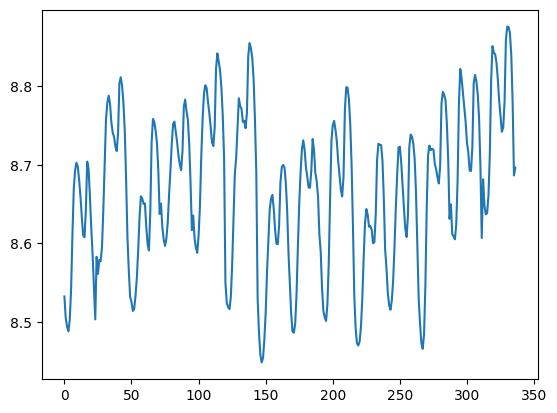

In [466]:
import matplotlib.pyplot as plt

plt.plot(y_trans)
plt.show()

In [ ]:
# 7. Select initial values for the parameters

In [29]:
# 8. Create first model - No ARMA errors 
ar_coeffs = None
ma_coeffs = None

In [ ]:
# 9. Create second model - ARMA errors 

# 10. Select model with the lowest AIC